In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
dataText = pd.read_csv("./train140.csv",encoding="latin-1")

In [11]:
dataText.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   datetime  1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [36]:
dataText["label"].value_counts()

4    800000
0    800000
Name: label, dtype: int64

In [21]:
testData = pd.read_csv("./test140.csv",encoding="latin-1")

In [35]:
testData["label"].value_counts()

4    182
0    177
2    139
Name: label, dtype: int64

In [24]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     498 non-null    int64 
 1   id        498 non-null    int64 
 2   datetime  498 non-null    object
 3   query     498 non-null    object
 4   user      498 non-null    object
 5   text      498 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


In [26]:
dataText

,label,id,datetime,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer1 = Tokenizer(num_words = 25000,oov_token='OOV',filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')

In [41]:
np.random.seed(44)
N = len(dataText)
shuffled_indices = np.random.permutation(N)
dataLabelNum = dataText["label"].copy()
train_index = shuffled_indices[:int(N*0.9)]
valid_index = shuffled_indices[int(N*0.9):]

train_text = dataText.iloc[train_index]
train_labelNum = dataLabelNum.iloc[train_index]

valid_text = dataText.iloc[valid_index]
valid_labelNum = dataLabelNum.iloc[valid_index]

In [42]:
trainSet = train_text.drop(columns = ['id','datetime','query','user','label'])
validSet = valid_text.drop(columns = ['id','datetime','query','user','label'])

train_labelNum,valid_labelNum,trainSet,validSet

(1545897    4
 141842     0
 1245796    4
 785684     0
 784358     0
           ..
 1146260    4
 1198472    4
 358495     0
 891790     4
 931128     4
 Name: label, Length: 1440000, dtype: int64,
 1578239    4
 285524     0
 1129823    4
 1594219    4
 1292100    4
           ..
 641120     0
 49723      0
 156845     0
 1305329    4
 1586964    4
 Name: label, Length: 160000, dtype: int64,
                                                       text
 1545897  im sooooo funny ik! camp is so fun! iguess????...
 141842                  offffft its rainingg so mucccccch 
 1245796                    emptying the inbox. #inboxZero 
 785684   Justine's gone from #Masterchef  will the show...
 784358   mad is hell i got a drive 2 queens in like 2 h...
 ...                                                    ...
 1146260  I have a feeling I'm too tired to sleep much  ...
 1198472  Going to bed now. Tomorrow the course starts e...
 358495   waiting for @jessoms to call me and tell me sh...
 89

due to the nature of the training set, this would be binary sentiment prediction, and will later set threshold on how to determine neutral label.

In [43]:
test_labelNum = testData["label"].copy()
testSet = testData["text"].copy()
test_labelNum, testSet

(0      4
 1      4
 2      4
 3      4
 4      4
       ..
 493    2
 494    0
 495    4
 496    0
 497    0
 Name: label, Length: 498, dtype: int64,
 0      @stellargirl I loooooooovvvvvveee my Kindle2. ...
 1      Reading my kindle2...  Love it... Lee childs i...
 2      Ok, first assesment of the #kindle2 ...it fuck...
 3      @kenburbary You'll love your Kindle2. I've had...
 4      @mikefish  Fair enough. But i have the Kindle2...
                              ...                        
 493    Ask Programming: LaTeX or InDesign?: submitted...
 494    On that note, I hate Word. I hate Pages. I hat...
 495    Ahhh... back in a *real* text editing environm...
 496    Trouble in Iran, I see. Hmm. Iran. Iran so far...
 497    Reading the tweets coming out of Iran... The w...
 Name: text, Length: 498, dtype: object)

In [45]:
trainLabel = tf.one_hot(train_labelNum.to_numpy(),2).numpy()
validLabel = tf.one_hot(valid_labelNum.to_numpy(),2).numpy()

In [53]:
# checking the number of popular words so that I can put initiate the tokenizer
import collections
temp_text = ' '.join(trainSet["text"])
words = temp_text.split()
counter = collections.Counter(words)

word_count = set()
for item in set(words):
    if counter[item]>35:
        word_count.add(item.lower())
        
len(word_count)

18045

In [61]:
tokenizer1 = Tokenizer(num_words = 18000,oov_token='OOV',filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')
tokenizer1.fit_on_texts(list(trainSet["text"].values))



In [62]:
trainLabel, validLabel

(array([[0., 0.],
        [1., 0.],
        [0., 0.],
        ...,
        [1., 0.],
        [0., 0.],
        [0., 0.]], dtype=float32),
 array([[0., 0.],
        [1., 0.],
        [0., 0.],
        ...,
        [1., 0.],
        [0., 0.],
        [0., 0.]], dtype=float32))

In [63]:
trainSeq1 = tokenizer1.texts_to_sequences(trainSet["text"])
trainPad1 = pad_sequences(trainSeq1, maxlen = 100, padding = 'pre', truncating = 'pre')
validSeq1 = tokenizer1.texts_to_sequences(validSet["text"])
validPad1 = pad_sequences(validSeq1, maxlen = 100, padding = 'pre', truncating = 'pre')


In [68]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(18000,output_dim = 16, input_length = 100,name="embedding",mask_zero=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,return_sequences=False)),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2,activation='softmax'),
    
])

model1.compile(optimizer = 'adam',loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           288000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 32)           4224      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 299,058
Trainable params: 299,058
Non-trainable params: 0
__________________________________________________

In [69]:
tsb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
model1.fit(trainPad1,trainLabel,epochs=8,batch_size=32,
          validation_data=(validPad1,validLabel),
           callbacks = [tsb_callback]
          )

Epoch 1/8
45000/45000 [==============================] - 905s 20ms/step - loss: 0.6567 - accuracy: 0.9165 - val_loss: 0.1572 - val_accuracy: 1.0000
Epoch 2/8
45000/45000 [==============================] - 896s 20ms/step - loss: 0.1293 - accuracy: 0.9712 - val_loss: 0.3157 - val_accuracy: 1.0000
Epoch 3/8
45000/45000 [==============================] - 897s 20ms/step - loss: 0.1673 - accuracy: 0.8823 - val_loss: 0.1918 - val_accuracy: 1.0000
Epoch 4/8
45000/45000 [==============================] - 897s 20ms/step - loss: 0.2193 - accuracy: 0.8247 - val_loss: 0.0386 - val_accuracy: 1.0000
Epoch 5/8
45000/45000 [==============================] - 898s 20ms/step - loss: 0.2973 - accuracy: 0.7998 - val_loss: 0.1623 - val_accuracy: 1.0000
Epoch 6/8
45000/45000 [==============================] - 897s 20ms/step - loss: 0.3950 - accuracy: 0.7867 - val_loss: 1.7950e-07 - val_accuracy: 1.0000
Epoch 7/8
45000/45000 [==============================] - 897s 20ms/step - loss: 0.4966 - accuracy: 0.7801 - 

In [74]:
train_labelNum.value_counts()

4    720306
0    719694
Name: label, dtype: int64

In [80]:
testSet,test_labelNum

(0      @stellargirl I loooooooovvvvvveee my Kindle2. ...
 1      Reading my kindle2...  Love it... Lee childs i...
 2      Ok, first assesment of the #kindle2 ...it fuck...
 3      @kenburbary You'll love your Kindle2. I've had...
 4      @mikefish  Fair enough. But i have the Kindle2...
                              ...                        
 493    Ask Programming: LaTeX or InDesign?: submitted...
 494    On that note, I hate Word. I hate Pages. I hat...
 495    Ahhh... back in a *real* text editing environm...
 496    Trouble in Iran, I see. Hmm. Iran. Iran so far...
 497    Reading the tweets coming out of Iran... The w...
 Name: text, Length: 498, dtype: object,
 0      4
 1      4
 2      4
 3      4
 4      4
       ..
 493    2
 494    0
 495    4
 496    0
 497    0
 Name: label, Length: 498, dtype: int64)

In [81]:
testSeq1 = tokenizer1.texts_to_sequences(testSet)
testPad1 = pad_sequences(testSeq1, maxlen = 100, padding = 'pre', truncating = 'pre')

In [82]:
pred1 = model1.predict(testPad1)
pred1

array([[9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.2603242e-06],
       [9.9999774e-01, 2.

In [83]:
testLabel = tf.one_hot(test_labelNum.to_numpy(),3).numpy()
testLabel

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [90]:
testLabel,test_labelNum
#4: [0,0,0]
#2: [0,0,1]
#0: [1,0,0]

(array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], dtype=float32),
 0      4
 1      4
 2      4
 3      4
 4      4
       ..
 493    2
 494    0
 495    4
 496    0
 497    0
 Name: label, Length: 498, dtype: int64)

In [85]:
trainLabel,train_labelNum

(array([[0., 0.],
        [1., 0.],
        [0., 0.],
        ...,
        [1., 0.],
        [0., 0.],
        [0., 0.]], dtype=float32),
 1545897    4
 141842     0
 1245796    4
 785684     0
 784358     0
           ..
 1146260    4
 1198472    4
 358495     0
 891790     4
 931128     4
 Name: label, Length: 1440000, dtype: int64)

In [96]:
def transformPred(nparr):
    output = []
    for item in nparr:
        if np.argmax(item) == 0:
            if item[0]>=0.6:
                output.append(0)
            else:
                if 
                output.append(2)
        else:
                output.append([0])
            else:
                output.append([0,0,1])
        
    return np.array(output)

In [99]:
import sklearn
import sklearn.metrics
pred1_t = transformPred(pred1)

#sklearn.metrics.confusion_matrix(testLabel,pred1_t),\
sklearn.metrics.accuracy_score(testLabel,pred1_t)

0.3654618473895582

In [113]:
#issue: way too overfit and need clean the input data
# replacing 4 into 1 to truly achieve the binary sentiment analysis
# will introduce threshold later
miniTrain = trainSet[:35000].copy()

In [114]:
tminiLabel = train_labelNum[:35000].copy()

In [115]:
tminiLabel.value_counts(),vminiLabel.value_counts()

(0    17631
 4    17369
 Name: label, dtype: int64,
 0    8758
 4    8742
 Name: label, dtype: int64)

In [116]:
minivalid = validSet[:17500].copy()
vminiLabel = valid_labelNum[:17500].copy()


In [117]:
tminiLabel,vminiLabel

(1545897    4
 141842     0
 1245796    4
 785684     0
 784358     0
           ..
 173424     0
 473979     0
 489592     0
 1480534    4
 649833     0
 Name: label, Length: 35000, dtype: int64,
 1578239    4
 285524     0
 1129823    4
 1594219    4
 1292100    4
           ..
 1195316    4
 426888     0
 10102      0
 211778     0
 597913     0
 Name: label, Length: 17500, dtype: int64)

In [118]:
vminiLabel.replace({4:1},inplace=True)
tminiLabel.replace({4:1},inplace=True)
tminiLabel,vminiLabel

(1545897    1
 141842     0
 1245796    1
 785684     0
 784358     0
           ..
 173424     0
 473979     0
 489592     0
 1480534    1
 649833     0
 Name: label, Length: 35000, dtype: int64,
 1578239    1
 285524     0
 1129823    1
 1594219    1
 1292100    1
           ..
 1195316    1
 426888     0
 10102      0
 211778     0
 597913     0
 Name: label, Length: 17500, dtype: int64)

In [273]:
# data cleaning then redo the tokenizer baseline
import re,nltk,string
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
def text_clean(x):
    x = x.lower()
    x = ' '.join([m for m in x.split(' ') if m not in stop_words])
    x = x.encode('ascii','ignore').decode()## characters that ascii not recognized like emoji
    x = re.sub(r'@\S+', ' ', x)## @ handler
    x = re.sub(r'#\S+', ' ', x)## hashtag
    x = re.sub(r'\'\w+', '', x)## ticks
    x = re.sub("https*\S+", " ", x)## http link
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    x = re.sub(r'\w*\d+\w*', '', x)## numbers
    x = re.sub(r'\s{2,}', ' ', x)## double space
    return x

trainClean = miniTrain.text.apply(text_clean)
validClean = minivalid.text.apply(text_clean)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JimmyGan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [274]:
token2 = Tokenizer(num_words = 2500,lower=True, split=" ", char_level=False,oov_token = 'OOV')
token2.fit_on_texts(trainClean)

trainSeq2 = token2.texts_to_sequences(trainClean)
trainPad2 = pad_sequences(trainSeq2,maxlen = 100,padding = 'pre',truncating = 'pre')

validSeq2 = token2.texts_to_sequences(validClean)
validPad2 = pad_sequences(validSeq2,maxlen = 100,padding = 'pre',truncating = 'pre')

In [278]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(2500,output_dim = 32, input_length = 100,name="embedding",mask_zero=False),
   # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False)),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2,activation='softmax'),
    
])

model2.compile(optimizer = 'adam',loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
model2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           80000     
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 64)                16640     
_________________________________________________________________
dense_30 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 66        
Total params: 98,786
Trainable params: 98,786
Non-trainable params: 0
_________________________________________________________________


In [279]:

train_lab2 = tf.one_hot(tminiLabel.to_numpy() , 2).numpy()
valid_lab2 =  tf.one_hot(vminiLabel.to_numpy(),2).numpy()
len(trainPad2)

35000

In [280]:
tsb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
hist2 = model2.fit(trainPad2,train_lab2,epochs=16,batch_size=64,
          validation_data=(validPad2,valid_lab2),
           callbacks = [tsb_callback]
          )

Epoch 1/16
547/547 [==============================] - 20s 29ms/step - loss: 0.6130 - accuracy: 0.6427 - val_loss: 0.5117 - val_accuracy: 0.7510
Epoch 2/16
547/547 [==============================] - 14s 25ms/step - loss: 0.4817 - accuracy: 0.7740 - val_loss: 0.5065 - val_accuracy: 0.7502
Epoch 3/16
547/547 [==============================] - 14s 25ms/step - loss: 0.4594 - accuracy: 0.7837 - val_loss: 0.5085 - val_accuracy: 0.7526
Epoch 4/16
547/547 [==============================] - 14s 25ms/step - loss: 0.4353 - accuracy: 0.7954 - val_loss: 0.5169 - val_accuracy: 0.7505
Epoch 5/16
547/547 [==============================] - 14s 25ms/step - loss: 0.4157 - accuracy: 0.8042 - val_loss: 0.5464 - val_accuracy: 0.7448
Epoch 6/16
547/547 [==============================] - 14s 25ms/step - loss: 0.3893 - accuracy: 0.8176 - val_loss: 0.5512 - val_accuracy: 0.7344
Epoch 7/16
547/547 [==============================] - 14s 25ms/step - loss: 0.3715 - accuracy: 0.8215 - val_loss: 0.5951 - val_accuracy:

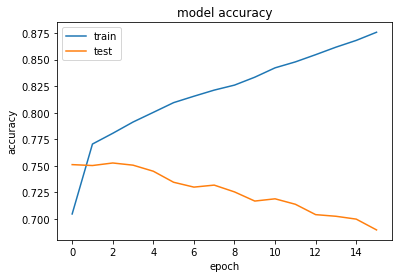

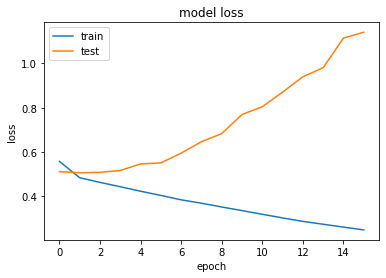

In [281]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

it still has the problem of overfitting the training data

In [282]:
testClean = testSet.apply(text_clean)
testSeq2 = token2.texts_to_sequences(testClean)
testPad2 = pad_sequences(testSeq2,maxlen = 100,padding = 'pre',truncating = 'pre')
pred2=model2.predict(testPad2)

In [283]:
def translate(resarr, cutoff):
    output = []
    for item in resarr:
        if item[0] == item[1]:
            output.append(2)
            continue
        if item[0]<=cutoff and item[1]<=cutoff:
            output.append(2)
        else:
            if np.argmax(item) == 0:
                output.append(0)
            else:
                output.append(4)
    return np.array(output)


In [284]:
test2 = test_labelNum.copy()
test2 = test2.to_numpy()

In [285]:
sklearn.metrics.confusion_matrix(test2,translate(pred2,0.5)),\
sklearn.metrics.accuracy_score(test2,translate(pred2,0.5))

(array([[116,   0,  61],
        [ 33,   0, 106],
        [ 41,   0, 141]], dtype=int64),
 0.5160642570281124)

In [163]:
test_labelNum[493]


2

In [167]:
testSet[493]

'Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] http://tinyurl.com/myfmf7'

In [172]:
sklearn.metrics.f1_score(test2,translate(pred2,0.5),average='micro')

0.5140562248995983

In [215]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(2500,output_dim = 32, input_length = 80,name="embedding",mask_zero=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False)),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2,activation='softmax'),
    
])
opt = tf.keras.optimizers.Adam(learning_rate = 0.0005,name ='Adam')
model3.compile(optimizer = 'adam',loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
model3.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 32)            80000     
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 80, 64)            16640     
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 64)                24832     
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 66        
Total params: 123,618
Trainable params: 123,618
Non-trainable params: 0
_______________________________________________

In [216]:
trainClean = trainSet.text.apply(text_clean)

validClean = validSet.text.apply(text_clean)
token3 = Tokenizer(num_words = 2500,oov_token = 'OOV')
token3.fit_on_texts(trainClean)
trainSeqfull = token3.texts_to_sequences(trainClean)
trainPadfull = pad_sequences(trainSeqfull,maxlen = 80,padding = 'pre',truncating = 'pre')

validSeqfull = token3.texts_to_sequences(validClean)
validPadfull = pad_sequences(validSeqfull,maxlen = 80,padding = 'pre',truncating = 'pre')

tlbfull = train_labelNum.copy()
vlbfull = valid_labelNum.copy()
tlbfull.replace({4:1},inplace=True)
vlbfull.replace({4:1},inplace=True)

train_lab3 = tf.one_hot(tlbfull.to_numpy() , 2).numpy()
valid_lab3 =  tf.one_hot(vlbfull.to_numpy(),2).numpy()

In [217]:


tsb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
hist3 = model3.fit(trainPadfull,train_lab3,epochs=8,batch_size=32,
          validation_data=(validPadfull,valid_lab3),
           callbacks = [tsb_callback]
          )

Epoch 1/16
22500/22500 [==============================] - 653s 29ms/step - loss: 0.4948 - accuracy: 0.7551 - val_loss: 0.4644 - val_accuracy: 0.7752
Epoch 2/16
22500/22500 [==============================] - 644s 29ms/step - loss: 0.4609 - accuracy: 0.7782 - val_loss: 0.4566 - val_accuracy: 0.7800
Epoch 3/16
22500/22500 [==============================] - 643s 29ms/step - loss: 0.4502 - accuracy: 0.7844 - val_loss: 0.4544 - val_accuracy: 0.7826
Epoch 4/16
22500/22500 [==============================] - 642s 29ms/step - loss: 0.4430 - accuracy: 0.7889 - val_loss: 0.4507 - val_accuracy: 0.7833
Epoch 5/16
22500/22500 [==============================] - 643s 29ms/step - loss: 0.4375 - accuracy: 0.7920 - val_loss: 0.4519 - val_accuracy: 0.7827
Epoch 6/16
22500/22500 [==============================] - 643s 29ms/step - loss: 0.4325 - accuracy: 0.7951 - val_loss: 0.4511 - val_accuracy: 0.7853
Epoch 7/16
22500/22500 [==============================] - 643s 29ms/step - loss: 0.4274 - accuracy: 0.7980

In [220]:
testClean = testSet.apply(text_clean)
testSeq3 = token3.texts_to_sequences(testClean)
testPad3 = pad_sequences(testSeq3,maxlen = 80,padding = 'pre',truncating = 'pre')
pred3=model3.predict(testPad3)


In [229]:
sklearn.metrics.confusion_matrix(test2,translate(pred3,0.6)),\
sklearn.metrics.accuracy_score(test2,translate(pred3,0.6))

(array([[123,  24,  30],
        [ 25,  34,  80],
        [ 20,  18, 144]], dtype=int64),
 0.6044176706827309)

In [230]:
def plothist(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

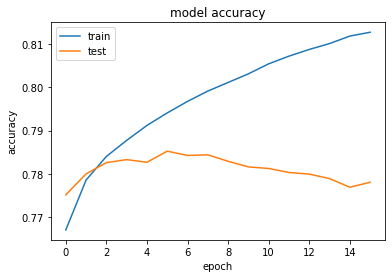

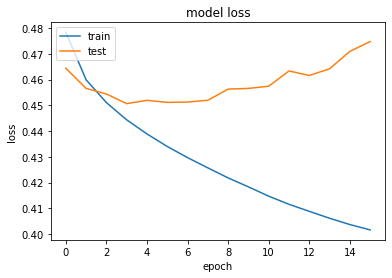

In [231]:
plothist(hist3)

In [234]:
idx_list = []
for idx,item in enumerate(test2):
    if item == 2:
        idx_list.append(idx)
for item in idx_list:
    print(pred3[item])
    

[0.03540772 0.96459234]
[0.11904386 0.8809562 ]
[0.18136497 0.81863505]
[0.1132116 0.8867884]
[0.55206347 0.44793648]
[0.08941063 0.9105894 ]
[0.08572751 0.9142725 ]
[0.05659481 0.9434052 ]
[0.18559338 0.81440663]
[0.05915511 0.9408449 ]
[0.05915512 0.9408449 ]
[0.32716405 0.67283595]
[0.31931672 0.68068326]
[0.44209737 0.55790263]
[0.9556553  0.04434473]
[0.15367706 0.8463229 ]
[0.52276206 0.4772379 ]
[0.08384918 0.91615075]
[0.14893088 0.85106915]
[0.4110015 0.5889985]
[0.02915245 0.97084755]
[0.29450238 0.7054976 ]
[0.03412197 0.965878  ]
[0.09435873 0.90564126]
[0.00929669 0.99070334]
[0.02125345 0.9787466 ]
[0.04831592 0.9516841 ]
[0.44486788 0.5551322 ]
[0.04554489 0.95445514]
[0.46196434 0.5380357 ]
[0.5399403 0.4600597]
[0.3606934 0.6393066]
[0.5313395 0.4686604]
[0.3497245  0.65027547]
[0.33858448 0.6614155 ]
[0.75199896 0.24800102]
[0.70998114 0.2900189 ]
[0.1472131 0.8527869]
[0.35602966 0.6439704 ]
[0.4852797  0.51472026]
[0.19670981 0.80329025]
[0.52928275 0.4707172 ]
[0.6

In [235]:
sklearn.metrics.confusion_matrix(test2,translate(pred3,0.6))

array([[123,  24,  30],
       [ 25,  34,  80],
       [ 20,  18, 144]], dtype=int64)

baseline is not that bad on unseen neutral considering the fact that it has never been tested before but the positve/negative sentiment still have around 75% accuracy ignoring the neutral cases.

In [312]:
text = ["why you acting you famous"]

txtseq = token3.texts_to_sequences(text)
txtpad = pad_sequences(txtseq,maxlen = 80,padding = 'pre',truncating = 'pre')
txtpred = model3.predict(txtpad)

In [313]:
txtpred

array([[0.231001 , 0.7689989]], dtype=float32)